# Avaliação Sprint 3

## Import das bibliotecas necessárias

In [1]:
import pandas as pd
from bs4 import BeautifulSoup
from urllib.request import urlopen
from pymongo import MongoClient
import spacy
from spacy import displacy
from spacy.symbols import VERB
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt


## Conexão com o banco de dados Mongo

In [2]:
client = MongoClient("localhost", 27017)
artigos_db = client["Artigos"]
artigos = artigos_db["Coleção_artigos"]
verbos_artigos = artigos_db["Coleção_verbos"]
entidades_artigos = artigos_db["Coleção_entidades"]

## Fazendo o scrapping dos artigos

In [3]:
urls = [
    "https://www1.folha.uol.com.br/banco-de-dados/2021/05/1921-transporte-de-cavalos-de-corrida-burla-proibicao-em-sao-paulo.shtml",
    "https://www1.folha.uol.com.br/banco-de-dados/2021/06/1921-apos-sucesso-nos-eua-pianista-guiomar-novaes-chega-a-sao-paulo.shtml",
    "https://www1.folha.uol.com.br/banco-de-dados/2021/05/1921-missao-italiana-vem-ao-brasil-buscar-ajuda-para-mutilados-na-guerra.shtml",
    "https://www1.folha.uol.com.br/banco-de-dados/2021/05/1971-franca-aprova-entrada-do-reino-unido-no-mercado-comum-europeu.shtml",
    "https://www1.folha.uol.com.br/banco-de-dados/2021/05/1921-empresa-de-campinas-vai-comecar-a-vender-carne-fresca-a-paulistanos.shtml",
    "https://www1.folha.uol.com.br/banco-de-dados/2021/05/1921-teatro-polytheama-em-ribeirao-preto-e-destruido-por-incendio.shtml",
    "https://www1.folha.uol.com.br/banco-de-dados/2021/04/1921-tracado-de-estrada-que-ligara-limeira-a-araras-e-estudado.shtml",
    "https://www1.folha.uol.com.br/banco-de-dados/2021/03/1971-guerra-civil-estoura-no-paquistao-oriental-que-deseja-independencia.shtml",
    "https://www1.folha.uol.com.br/banco-de-dados/2021/03/1921-estrada-vai-facilitar-ligacao-de-sao-paulo-com-triangulo-mineiro-e-goias.shtml",
    "https://www1.folha.uol.com.br/banco-de-dados/2021/02/1921-autoridade-do-reino-unido-reafirma-luta-contra-movimento-irlandes.shtml"
] # lista das urls dos artigos



In [4]:
lista_artigos = []
for url in urls:
    response = urlopen(url)
    html = response.read().decode('utf8')

    soup = BeautifulSoup(html, 'html.parser')

    # Extraindo o texto de cada paragrafo dos artigos, sem as tags html
    paragrafos_artigo = [paragrafo.text for paragrafo in soup.find('div', {'class': 'c-news__body'}).findAll('p')]

    lista_artigos.append({'Paragrafos': paragrafos_artigo})



In [5]:
lista_artigos[0]

{'Paragrafos': ['Está sendo burlada a proibição de transportar animais nas estradas que convergem a São Paulo.',
  'Dias depois do aparecimento da peste bovina nos arredores da capital, as autoridades sanitárias tinham lembrado o governo da necessidade de estabelecer essa proibição.',
  'Apesar da medida, jornais noticiaram a ida e vinda de cavalos de corrida entre a capital e Santos. A fim de mascarar a manobra, os animais são enviados para São Bernardo e de lá são transportados para a outra cidade.',
  'Isso ocorre como se a transmissão da peste não fosse possível nas patas de cavalos ingleses, que custam caro.']}

## Salvando os artigos no MongoDB

In [6]:
artigos.insert_one({'Artigos': lista_artigos})


## Criando um dataset com os paragrafos dos artigos

In [7]:
paragrafos_artigos = artigos.find({'Artigos': lista_artigos}) # Retirando os paragrafos direto do mongo
for paragrafo in paragrafos_artigos:
    # Os paragrafos são transformados em dataframe
    df_paragrafos = pd.DataFrame(paragrafo['Artigos'])
df_paragrafos.head()

,Paragrafos
0,[Está sendo burlada a proibição de transportar...
1,[A pianista Guiomar Novaes chegou a São Paulo ...
2,[A missão italiana de mutilados na guerra cheg...
3,[A França deu o seu “sim” para o ingresso do R...
4,"[Uma empresa particular, de Campinas, vai pass..."


In [8]:
nlp = spacy.load("pt_core_news_sm")
doc = nlp(str(df_paragrafos.Paragrafos))

## Retirando as stop words

In [9]:
def retira_stop_words(artigos):
    palavras_tokens = []

    # Transforma cada palavra do artigo em token
    nlp = spacy.load("pt_core_news_sm") # nlp em português
    doc = nlp(str(artigos))

    for palavra_token in doc:
        palavra = not palavra_token.is_stop and palavra_token.is_alpha

        if palavra:
            # Adiciona na lista e deixa a palavra em minusculo
            palavras_tokens.append(palavra_token.text.lower())
    
    return ' '.join(palavras_tokens)

In [10]:
artigos_processados = []

for paragrafos in df_paragrafos.Paragrafos:
    artigos_processados.append(retira_stop_words(paragrafos))

In [11]:
df_paragrafos["Paragrafos_processados"] = artigos_processados
df_paragrafos.head()

,Paragrafos,Paragrafos_processados
0,[Está sendo burlada a proibição de transportar...,sendo burlada proibição transportar animais es...
1,[A pianista Guiomar Novaes chegou a São Paulo ...,pianista guiomar novaes chegou paulo veio trem...
2,[A missão italiana de mutilados na guerra cheg...,missão italiana mutilados guerra chegou rio ja...
3,[A França deu o seu “sim” para o ingresso do R...,frança deu ingresso reino unido mercado comum ...
4,"[Uma empresa particular, de Campinas, vai pass...",empresa particular campinas passar vender carn...


## Obtendo os verbos e as entidades

In [12]:
# Listando os verbos
lista_verbos = []
nlp = spacy.load("pt_core_news_sm") # nlp em português
doc = nlp(str(lista_artigos))

for palavra in doc:
    if palavra.head.pos == VERB:
        if palavra.head.orth_ not in lista_verbos:
            # Transforma em string e adiciona na lista de verbos
            lista_verbos.append(str(palavra.head))

lista_verbos
verbos_artigos.insert_one({'Verbos': lista_verbos})

In [13]:
# Listando as entidades
lista_entidades = []
doc = nlp(str(lista_artigos))

for palavra in doc.ents:
    if palavra.orth_ not in lista_entidades:
        if len(palavra) > 2:
            lista_entidades.append(palavra.orth_)

entidades_artigos.insert_one({'Entidades': lista_entidades})

## Gerando uma núvem de palavras

In [14]:
# Função gerar núvem de palavras
def gerar_nuvem_palavras(artigos):
    todas_palavras = ''.join([text for text in artigos])
    nuvem_palavras = WordCloud(width=800, 
                            height=500,
                            max_font_size=110,
                            collocations=False).generate(todas_palavras)
                            
    plt.figure(figsize=(10,7)) # Tamanho da figura
    plt.imshow(nuvem_palavras)
    plt.axis("off") # Plota apenas a imagem, fora do plano cartesiano
    plt.show()

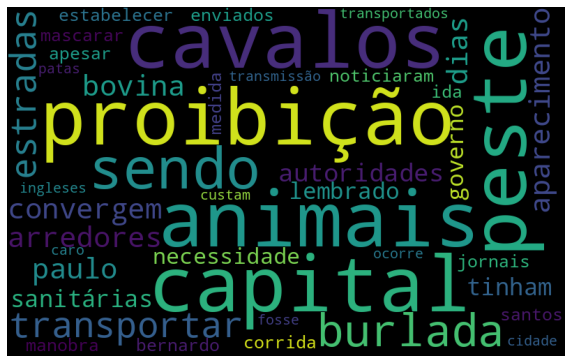

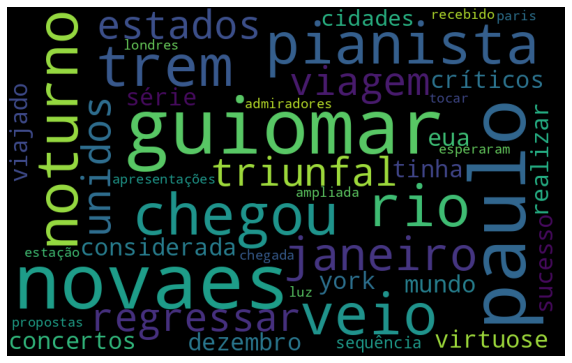

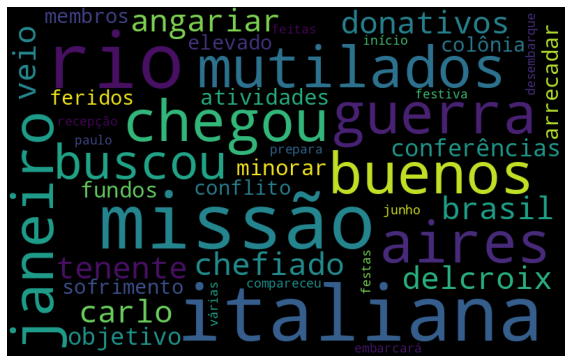

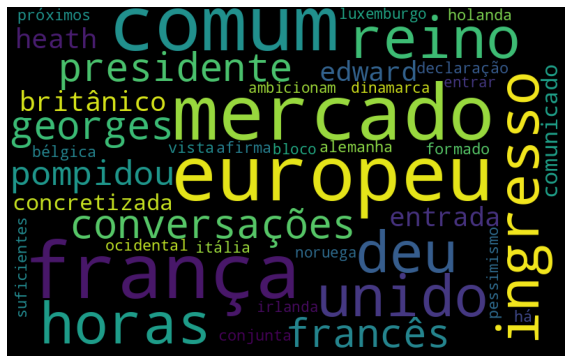

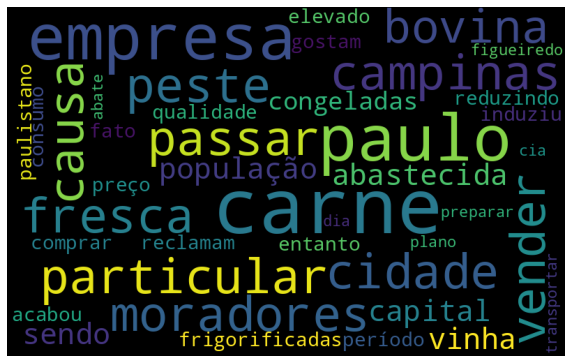

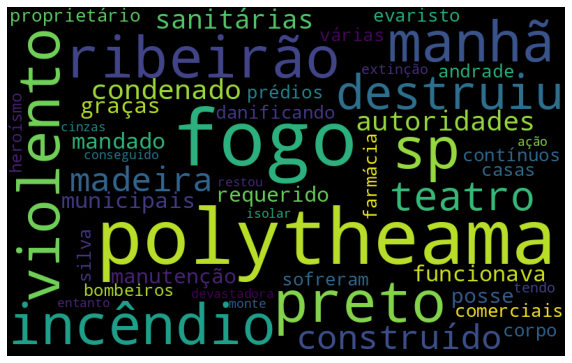

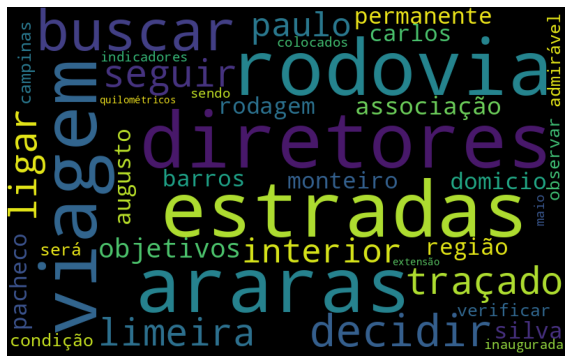

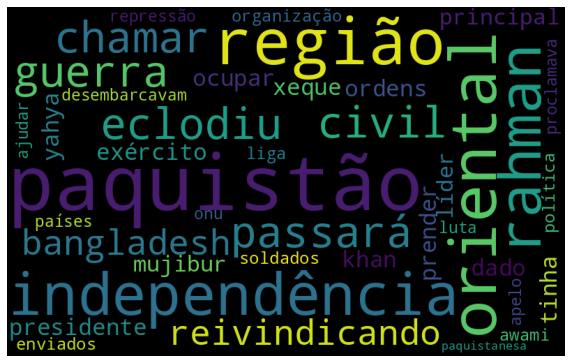

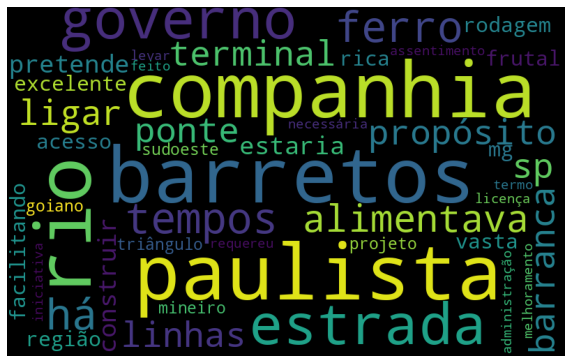

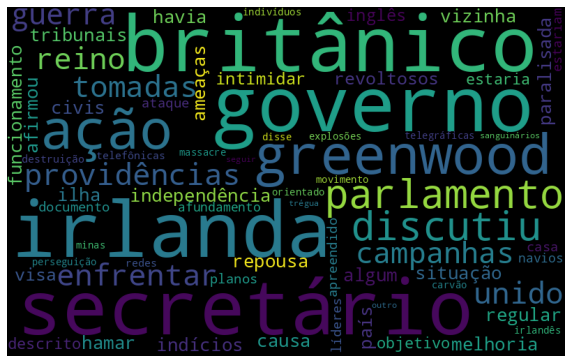

In [15]:
for i in range(0, 10):
    paragrafo_artigo = str(df_paragrafos.Paragrafos_processados[i])
    gerar_nuvem_palavras(paragrafo_artigo)

## Treinamento do dataset - Tweeter